In [1]:
from katsu.katsu_math import np, set_backend_to_jax, broadcast_kron
from katsu.mueller import linear_polarizer, linear_retarder

set_backend_to_jax()

import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from jax import random
from jax.scipy.special import factorial

# Set up Illuminated Aperture

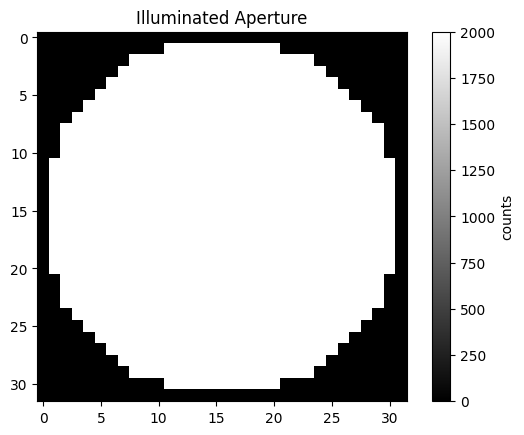

In [2]:
# set up simulation parameters for spatially-varying data
NPIX = 32
N_PHOTONS = 2000

# set up illuminated pupil
x = np.linspace(-1, 1, NPIX)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask = mask.at[r < 1].set(1)
aperture = mask * N_PHOTONS

plt.figure()
plt.title("Illuminated Aperture")
plt.imshow(aperture, cmap='grey')
plt.colorbar(label='counts')
plt.show()

# Set up Noisy Detector

This will be Poisson-dominated

In [3]:
def add_camera_noise(Nphotons, qe=1., dark_current=0, bitdepth=12, seed=random.key(42)):
    """Simulate a camera exposure

    function from http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/
    with modifications to support Jax behavior

    Parameters
    ----------
    Nphotons : int
        number of photons incident on a camera pixel
    qe : float, optional
        electrons per photon, by default 0.69
    dark_current : float, optional
        standard deviation of electrons, by default 2.29
    bitdepth : int, optional
        number of bits detector can resolve, by default 12
    seed : np.random.RandomState, optional
        random seed for simulation, by default np.random.RandomState(seed=42)
    """
    # photon noise
    photons = random.poisson(seed, Nphotons)

    # convert to electrons
    electrons = qe * photons

    # dark current
    electrons_out = random.normal(seed) / 1e3 + electrons

    # ADU
    max_adu = int(2**bitdepth - 1)
    adu = (electrons_out).astype(int)
    adu = adu.at[adu > max_adu].set(max_adu)

    return adu

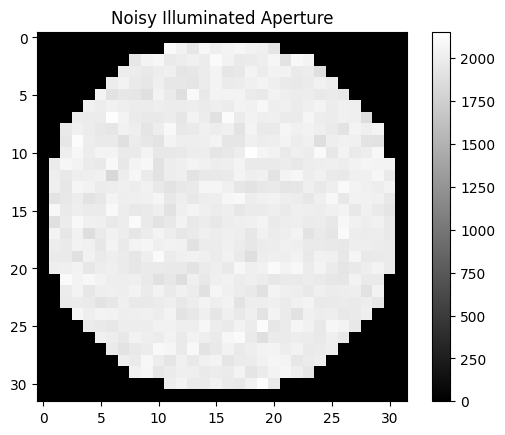

In [4]:
plt.figure()
plt.title("Noisy Illuminated Aperture")
plt.imshow(add_camera_noise(aperture), cmap='grey')
plt.colorbar()
plt.show()

# Generate a Spatially-resolved forward model

This will be a function of the illumination and model parameters

In [5]:
STEPS_DEG = 2.5
ANGULAR_RATIO = 2.5

def measurement(x, noisy=True):
    """Create simulated power measurement

    Parameters
    ----------
    x : list or array
        vector of model parameters

    Returns
    -------
    array
        simulated power array of shape NPIX x NPIX x N_ROTATIONS
    """

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]
    increment_psg_wvp = x[3]

    starting_angle_psa_pol = x[4]
    starting_angle_psa_wvp = x[5]
    retardance_psa_wvp = x[6]
    increment_psa_wvp = x[7]

    # set up PSG angles
    psg_angles = np.arange(0, 181 + STEPS_DEG, STEPS_DEG) * increment_psg_wvp
    psg_angles = np.radians(psg_angles) + starting_angle_psg_wvp

    psa_angles = np.arange(0, (181 + STEPS_DEG)*ANGULAR_RATIO, STEPS_DEG * ANGULAR_RATIO) * increment_psa_wvp
    psa_angles = np.radians(psa_angles) + starting_angle_psa_wvp

    shapes = [NPIX, NPIX, psa_angles.shape[0]]

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)
    psa_pol = linear_polarizer(starting_angle_psa_pol)

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp
    M = Ma @ Mg

    if noisy:
        power = []
        _p = M[..., 0, 0]
        _p = np.moveaxis(_p, -1, 0)

        for p in _p:
            power.append(add_camera_noise(p * N_PHOTONS))

        power = np.asarray(power)

    else:
        power = M[..., 0, 0] * N_PHOTONS


    return power

def calibrated_measurement(x, power):

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]
    increment_psg_wvp = x[3]

    starting_angle_psa_pol = x[4]
    starting_angle_psa_wvp = x[5]
    retardance_psa_wvp = x[6]
    increment_psa_wvp = x[7]

    # set up PSG angles
    psg_angles = np.arange(0, 181 + STEPS_DEG, STEPS_DEG) * increment_psg_wvp
    psg_angles = np.radians(psg_angles) + starting_angle_psg_wvp

    psa_angles = np.arange(0, (181 + STEPS_DEG)*ANGULAR_RATIO, STEPS_DEG * ANGULAR_RATIO) * increment_psa_wvp
    psa_angles = np.radians(psa_angles) + starting_angle_psa_wvp

    shapes = [NPIX, NPIX, psa_angles.shape[0]]

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)
    psa_pol = linear_polarizer(starting_angle_psa_pol)

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp

    PSG = Mg[..., :, 0]
    PSA = Ma[..., 0, :]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
    Winv = np.linalg.pinv(Wmat)
    power_expand = power[..., np.newaxis]

    # Do the data reduction
    M_meas = Winv @ power_expand
    M_meas = M_meas[..., 0]

    return M_meas.reshape([*M_meas.shape[:-1], 4, 4])

# Set up Truth Simulation

- starting_angle_psg_pol = x[0]
- starting_angle_psg_wvp = x[1]
- retardance_psg_wvp = x[2]
- increment_psg_wvp = x[3]

- starting_angle_psa_pol = x[4]
- starting_angle_psa_wvp = x[5]
- retardance_psa_wvp = x[6]
- increment_psa_wvp = x[7]

In [6]:
x_truth = [
    0, # starting angle psg pol
    0, # starting angle psg wvp
    np.pi / 2, # retardance psg wvp
    1, # error in psg wvp increment
    0, # starting angle psa pol
    0, # starting angle psa wvp
    np.pi / 2, # retardance psa wvp
    1 # error in psa wvp increment
]

In [7]:
power_truth = measurement(x_truth)

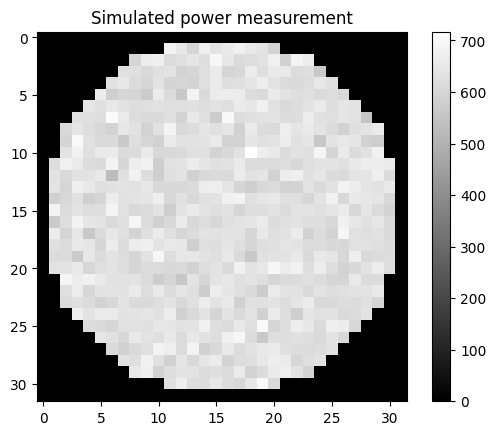

/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in negative
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in equal
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in less
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3749: RuntimeWarning: divide by zero encountered in multiply
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3749: RuntimeWarning: divide by zero encountered in add
  low, high = de

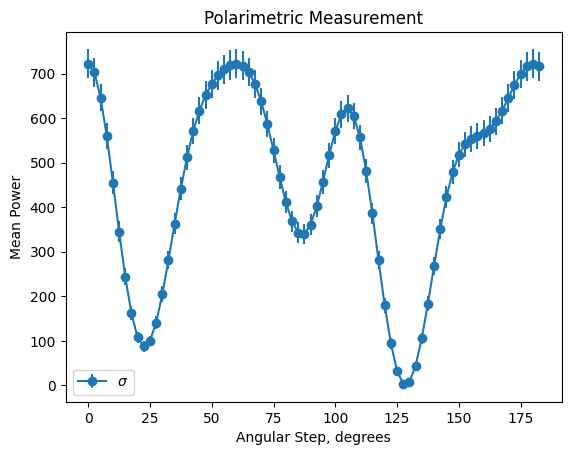

In [8]:
psg_angles = np.arange(0, 181 + STEPS_DEG, STEPS_DEG)

plt.figure()
plt.title("Simulated power measurement")
plt.imshow(mask * power_truth[4], cmap='grey')
plt.colorbar()
plt.show()

mean_power = np.mean(mask * power_truth, axis=(1, 2))
mean_std = []
for _p in power_truth:
    frame = np.copy(_p) - np.mean(_p[mask==1])
    mean_std.append(np.std(frame[mask==1]))

plt.figure()
plt.errorbar(psg_angles, mean_power, yerr=mean_std, marker='o', label=r'$\sigma$')
plt.xlabel('Angular Step, degrees')
plt.ylabel('Mean Power')
plt.title('Polarimetric Measurement')
plt.legend()
plt.show()

# Set up the Likelihood Function

Consider a collection of random variables $\vec{X} = x_1, x_2, x_3, ...$ which follow a Poisson distribution with expectation $\lambda$. The Probability distribution function is 

$$p(x_i | \lambda) = \frac{e^{-\lambda} \lambda^{x_{i}}}{x_{i}!}$$

Here $x_{i}$ would be our observed photons and $\lambda$ is what the model predicts the expectation value of the arriving photons would be. Next we compute the likelihood of all the events $x_{i}$ by taking the product of the PDFs.

$$ P(\lambda) = \prod_{i=0}^{N} p(x_i | \lambda) $$

By computing the log-likelihood, this can be a simple sum

$$ \mathcal{L} = ln (P(\lambda)) = -N \lambda + \sum_{i=0}^{N} x_i ln(\lambda) - \sum_{i=0}^{N} ln(x_i !)$$

In [9]:
# def factorial(x):

#     if x > 0:

#         return x * factorial(x-1)
    
#     else:
#         return 1
from scipy.special import factorial

def logpdf(lam, xi):

    if type(xi) == int:
        N = 1
        factorials = factorial(xi)
    else:
        N = xi.shape[0]

        # evaluate factorials
        # factorials = []
        # for x in xi:
        #     factorials.append(factorial(x))
        # factorials = np.asarray(factorials)
        factorials = factorial(xi)

    Nlam = N * lam
    sumxln = np.sum(xi * np.log(lam))


    sumlnxfac = np.sum(np.log(factorials))

    return -Nlam + sumxln - sumlnxfac

Test against the `scipy.stats` module

In [10]:
from scipy.stats import poisson
help(poisson.logpmf)

Help on method logpmf in module scipy.stats._distn_infrastructure:

logpmf(k, *args, **kwds) method of scipy.stats._discrete_distns.poisson_gen instance
    Log of the probability mass function at k of the given RV.
    
    Parameters
    ----------
    k : array_like
        Quantiles.
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        Location parameter. Default is 0.
    
    Returns
    -------
    logpmf : array_like
        Log of the probability mass function evaluated at k.



In [11]:
lams = [1, 2, 3]
xis = [2, 4, 6]

for l, x in zip(lams, xis):
    print('Scipy says = ', poisson.logpmf(x, l))
    print('Katsu says = ', logpdf(l, x))

Scipy says =  -1.6931471805599454
Katsu says =  -1.6931471805599454
Scipy says =  -2.4054651081081646
Katsu says =  -2.4054651081081646
Scipy says =  -2.987577480001443
Katsu says =  -2.987577480001443


Looks good to me, now we can do maximum likelihood stuff. What happens if we just throw in some random values?

In [44]:
x_model = [
    0, # starting angle psg pol
    np.pi / 4, # starting angle psg wvp
    np.pi / 2, # retardance psg wvp
    1, # error in psg wvp increment
    0, # starting angle psa pol
    3 * np.pi / 7, # starting angle psa wvp
    np.pi / 2, # retardance psa wvp
    1 # error in psa wvp increment
]

# Get expectation values
model_expectation = measurement(x_model, noisy=False)
model_expectation = np.moveaxis(model_expectation, -1, 0)

# Get the log likelihood
log_likelihood = []
for lam, xi in zip(model_expectation, power_truth):
    log_likelihood.append(poisson.logpmf(xi[mask==1], lam[mask==1]))

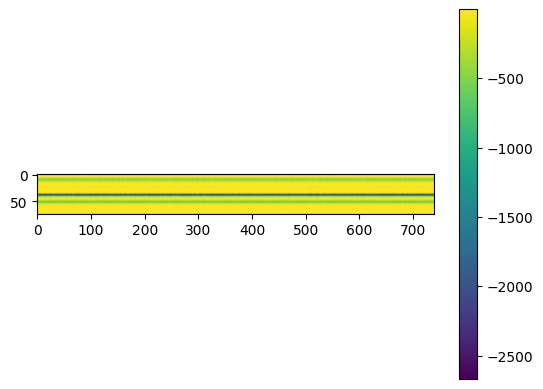

In [45]:
plt.imshow(np.asarray(log_likelihood))
plt.colorbar()

The log-likelihood gets really low. What happens if we feed this the true parameters?

In [46]:
# Get expectation values
model_expectation = measurement(x_truth, noisy=False)
model_expectation = np.moveaxis(model_expectation, -1, 0)

# Get the log likelihood
log_likelihood = []
for lam, xi in zip(model_expectation, power_truth):
    log_likelihood.append(poisson.logpmf(xi[mask==1], lam[mask==1]))

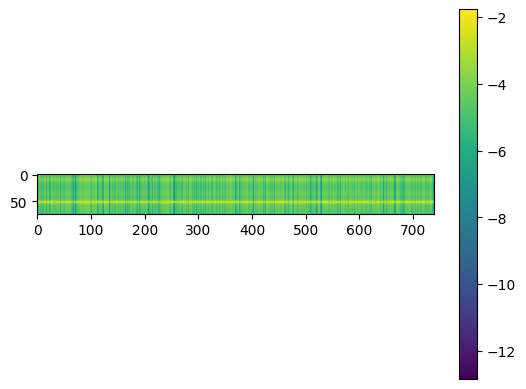

In [47]:
plt.imshow(np.asarray(log_likelihood))
plt.colorbar()

The likelihood gets orders of magniutde larger! So maximizing the likelihood does bring us closer to the true result. The next question is if we can get there via optimization, without knowing anything about the original state of the instrument.